# 분류와 서포트 벡터 머신 (SVM)

서포트 벡터 머신은 최적의 `결정 경계(decision boundary)`를 찾아 데이터를 분류하는 기계 학습 알고리즘이다.

수학적 원리보다는 직관적 이해만 확보하고, 실제 구현에 집중한다.

우리는 이번에 다음 두 가지 순서로 학습한다.

1. 이론: 분류`Clustering`
2. SVM 원리의 직관적 이해
3. 구현과 실습

## 1. 이론: 분류(Clustering)

분류는 데이터를 정당한 기준을 정하여 n개의 그룹으로 나누는 작업이다.

수학적인 방법으로 데이터를 분류하는 방법이 몇 가지가 있다.

1. **SVM (Support Vector Machine)**: 데이터를 분류하는 결정 경계를 찾는 알고리즘
2. **KNN (K-Nearest Neighbors)**: 새로운 데이터 포인트를 가장 가까운 K개의 이웃 데이터로 분류하는 알고리즘
3. **Decision Tree**: 데이터를 분류하기 위해 트리 구조를 사용하는 알고리즘
4. **Random Forest**: 여러 개의 결정 트리를 사용하여 데이터를 분류하는 앙상블 학습 방법

이 외에도 많은 분류 알고리즘이 존재하지만, 우리는 `SVM`, `KNN`, `Random Forest`만 배우고 나머지는 소개만 한다.

## 회귀 vs 분류

회귀는 연속적인 값을 예측하는 작업이고, 분류는 데이터를 정해진 그룹으로 나누는 작업이다. 둘은 목적이 아예 다르다.


## 1. SVM 원리의 직관적 이해

구경 잘 하고, 용어 기억 할 것. 주요 용어는 다음과 같다.

1. **결정 경계(decision boundary)**: 데이터를 분류하는 경계선
2. **서포트 벡터(support vector)**: 결정 경계를 정의하는 데이터 포인트
3. **마진(margin)**: 결정 경계와 서포트 벡터 사이의 거리

In [ ]:
# class A, class B 정의
import numpy as np
import matplotlib.pyplot as plt

# 중심이 (a, b), norm_dist d인 점 n개 생성
def generate_points(a, b, d, n):
    return np.random.normal(loc=[a, b], scale=d, size=(n, 2))

cls_a = generate_points(0, 0, 1.5, 50)  # 클래스 A
cls_b = generate_points(3, 3, 1.4, 50)  # 클래스 B

# 클래스 A와 B의 점들을 시각화
plt.scatter(cls_a[:, 0], cls_a[:, 1], label='Class A', color='blue')
plt.scatter(cls_b[:, 0], cls_b[:, 1], label='Class B', color='red')
plt.title('Class A and Class B Points')
plt.legend()
plt.show()

위 두 클래스를 구분할 수 있는 적당한 선을 하나 상상해보자.

SVM은 이 선을 찾는 수학적 방법이다.

이때 둘을 구분하는 선을 **결정 경계(decision boundary)**라고 한다.

In [ ]:
# 결정 경계 시각화
plt.figure(figsize=(10, 6))
plt.scatter(cls_a[:, 0], cls_a[:, 1], label='Class A', color='blue')
plt.scatter(cls_b[:, 0], cls_b[:, 1], label='Class B', color='red')

# SVM 모델 학습
from sklearn import svm
model = svm.SVC()  # 다항 커널 사용
model.fit(np.vstack((cls_a, cls_b)), [0]*len(cls_a) + [1]*len(cls_b))

# 결정 경계 그리기
def plot_decision_boundary(model, X, ax=None):
    if ax is None:
        ax = plt.gca()
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()

    xx, yy = np.meshgrid(np.linspace(xlim[0], xlim[1], 100),
                         np.linspace(ylim[0], ylim[1], 100))
    Z = model.decision_function(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    # 서포트 벡터 시각화
    ax.scatter(model.support_vectors_[:, 0], model.support_vectors_[:, 1],
               s=100, facecolors='none', edgecolors='k', label='Support Vectors')

    ax.contour(xx, yy, Z, colors='k', levels=[0], alpha=0.5,
               linestyles='--')

plot_decision_boundary(model, np.vstack((cls_a, cls_b)))
plt.title('Decision Boundary for Class A and Class B')
plt.legend()
plt.show()

#### Practice1. 생각해보기

1. SVM은 3개 이상의 클래스를 구분할 수 있을까?
2. 만약 SVM으로 3개 이상의 클래스를 구분해야 한다면, 어떻게 하면 될까?
3. SVM은 비선형 데이터도 분류할 수 있을까? 만약 그렇다면, 어떻게 하면 될까?
4. SVM은 어떤 상황에서 잘 작동할까? 어떤 상황에서는 잘 작동하지 않을까?

## 2. 구현과 실습

SVM 모델을 실제로 사용할 수 있도록 단계별로 구현하고, 시각화하여 어떤 식으로 동작하는지 이해할 것이다.

1. Encoding/Decoding
2. SVM 모델 선언과 학습
3. PCA 변환과 시각화

### 2.1. Encoding/Decoding

전처리 - 학습 - 평가 - 활용 과정 중 전처리 과정이다.

`데이터 로드 -> 분류 라벨 판단 -> 숫자로 변환` 작업의 한 방법.

`Label Encoding`은 문자열로 되어 있는 라벨 값을 숫자로 변환하는 방식이다. 구체적으로 두 가지를 배운다.

1. `Label Encoding`: 문자열 라벨을 0 이상의 정수로 변환
2. `Label Decoding`: 숫자 라벨을 문자열로 역변환
3. `Label Classes`: 어떤 클래스가 있는지 조회
4. 데이터셋에 인코딩한 라벨 추가하기

In [ ]:
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

iris = sns.load_dataset('iris')
x = iris.iloc[:, :-1]
y = iris.iloc[:, -1]

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)

le = LabelEncoder()
le.fit_transform(y)

In [ ]:
le.fit(y)
le.classes_
le.transform(['setosa'])
le.inverse_transform([1, 2])

# 역변환
yy_decoded = le.inverse_transform([0, 1, 2])
yy_decoded

In [ ]:
# 어떤 클래스가 있는지 조회
le.classes_

In [ ]:
iris['species_encoded'] = y_encoded

In [ ]:
iris

## Practice1. Label Encoding, Decoding

1. `LabelEncoder`로 `titanic` 데이터셋의 `who`을 encoding/decoding하고 어떤 클래스가 있는지 확인해본다.
2. `LabelEncoder`로 `titanic` 데이터셋의 `embark_town`을 encoding/decoding하고 어떤 클래스가 있는지 확인해본다.
3. `LabelEncoder`로 `penguins` 데이터셋의 `species`을 encoding/decoding하고 어떤 클래스가 있는지 확인해본다.
4. `LabelEncoder`로 `penguins` 데이터셋의 `island`을 encoding/decoding하고 어떤 클래스가 있는지 확인해본다.

In [ ]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
le.fit(y)
le.transform(y)
le.classes_
le.inverse_transform([1, 2])

In [ ]:
# 1번
import seaborn as sns
from sklearn.preprocessing import LabelEncoder

titanic = sns.load_dataset('titanic')
le_who = LabelEncoder()
le_who.fit(titanic['who'])
le_who.classes_

In [ ]:
# 2번
col = 'embark_town'
label_col = 'embark_town_label'

le2 = LabelEncoder()
titanic[label_col] = le2.fit_transform(titanic[col])
print("클래스:", le2.classes_)
print("라벨:", le2.transform(le2.classes_))

titanic

In [ ]:
# 3번
le = LabelEncoder()
penguins = sns.load_dataset('penguins')
species_label = le.fit_transform(penguins['species'])
penguins['species_label'] = species_label
print("클래스:", le.classes_)
print("라벨:", le.transform(le.classes_))
penguins

In [ ]:
# 4번
island_label = le.fit_transform(penguins['island'])
penguins['island_label'] = island_label
print("클래스:", le.classes_)
print("라벨:", le.transform(le.classes_))
penguins

In [ ]:
# 데이터프레임에 저장
# titanic, who 열
titanic = sns.load_dataset('titanic')
t = titanic['who']
le_who = LabelEncoder()
titanic['who_label'] = le_who.fit_transform(t)
titanic

In [ ]:
penguins = sns.load_dataset('penguins')
le_species = LabelEncoder()
penguins['species_label'] = le_species.fit_transform(penguins['species'])
penguins

### 2.2 SVM 모델 선언과 학습

SVM 모델을 선언하고, 학습하는 과정을 살펴보자. 세부적으로 다음을 배운다.

1. SVM 모델의 선언
2. 모델 학습과 예측값 생성

In [ ]:
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split as tts
from sklearn.svm import SVC

iris = sns.load_dataset('iris')
xx = iris.iloc[:, :-1]
yy = iris.iloc[:, -1]

x_train, x_test, y_train, y_test = tts(xx, yy, test_size=0.2)

# 모델선언 kernel='linear' or kernel='rbf' or kernel='sigmoid'
model = SVC(kernel='poly', degree=3)
model.fit(x_train, y_train)

#### Practice2. 다른 커널을 사용한 모델 선언, 학습하기

SVM은 다양한 커널 함수를 지원한다. `kernel` 파라미터를 변경하여 다른 커널을 사용해보자.

지원하는 커널들 : `poly`, `rbf`, `sigmoid`

<주의> `poly` 커널은 degree 파라메터를 필요로 한다. degree=4로 설정한다.

In [ ]:
# 1번
lin_model_poly = svm.SVC(kernel='poly', degree=1)
lin_model_poly.fit(x_train, y_train)

In [ ]:
# 2번
lin_model_rbf = svm.SVC()
lin_model_rbf.fit(x_train, y_train)

In [ ]:
# 3번
lin_model_sigmoid = svm.SVC(kernel='sigmoid')
lin_model_sigmoid.fit(x_train, y_train)

In [ ]:
le_island = LabelEncoder()

penguins.dropna(inplace=True)

island_label = le_island.fit_transform(penguins['island'])
penguins['island_label'] = island_label
penguins.columns
xx = penguins[['bill_length_mm', 'bill_depth_mm',
       'flipper_length_mm', 'body_mass_g', 'island_label']]
yy = penguins['species']

x_train, x_test, y_train, y_test = tts(xx, yy, test_size=0.2)

# SVM 모델 선언
svc = SVC(kernel='rbf')
svc.fit(x_train, y_train)

y_pred = svc.predict(x_test)
y_pred

### 2.3 PCA 변환과 시각화

앞서 만든 SVC 모델의 분류 결과를 그래프로 그릴 것이다.

이때 고차원 데이터는 평면에 나타내려면 차원 축소를 진행해야 한다.

그 방법 중 하나로 주성분분석`PCA(Principal Component Analysis)`를 사용한다.

이번에 할 내용은 아래와 같다.

1. 고차원 데이터 선택
2. PCA 변환기 선언
3. PCA 변환 수행
4. 시각화

In [ ]:
# 예시 생성을 위한 코드 - 배울 대상 아님
import numpy as np
import matplotlib.pyplot as plt
import koreanize_matplotlib
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

# 2D 예시로 직관적 설명
np.random.seed(42)
# 기울어진 타원형 데이터 생성 - 유효한 공분산 행렬 사용
mean = [0, 0]
cov = [[3, 1.5], [1.5, 1]]  # 수정된 공분산 행렬
data = np.random.multivariate_normal(mean, cov, 200)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# 왼쪽: 원본 데이터와 회전하는 축
ax1.scatter(data[:, 0], data[:, 1], alpha=0.5)
ax1.set_title('데이터를 여러 각도에서 보기')
ax1.set_xlim(-6, 6)
ax1.set_ylim(-6, 6)
ax1.set_aspect('equal')
ax1.grid(True, alpha=0.3)

# 오른쪽: 각 방향으로의 투영 분산
angles = np.linspace(0, np.pi, 180)
variances = []

for angle in angles:
    # 회전 벡터
    direction = np.array([np.cos(angle), np.sin(angle)])
    # 해당 방향으로 투영
    projections = data @ direction
    variances.append(np.var(projections))

ax2.plot(angles * 180/np.pi, variances)
ax2.set_xlabel('회전 각도 (도)')
ax2.set_ylabel('투영 분산')
ax2.set_title('각 방향으로 투영했을 때의 분산')
ax2.grid(True, alpha=0.3)

# 최대 분산 방향 표시
max_idx = np.argmax(variances)
max_angle = angles[max_idx]
ax2.axvline(max_angle * 180/np.pi, color='red', linestyle='--',
            label=f'최대 분산 방향: {max_angle*180/np.pi:.1f}°')
ax2.legend()

# 원본 데이터에 주성분 축 그리기
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca.fit(data)

# 주성분 벡터 그리기
origin = np.mean(data, axis=0)
for i, (comp, var) in enumerate(zip(pca.components_, pca.explained_variance_)):
    ax1.arrow(origin[0], origin[1],
              comp[0] * np.sqrt(var) * 2,
              comp[1] * np.sqrt(var) * 2,
              color=['red', 'blue'][i],
              width=0.1,
              head_width=0.3,
              label=f'PC{i+1} ({pca.explained_variance_ratio_[i]:.1%})')
ax1.legend()

plt.tight_layout()
plt.show()

# 공분산 행렬 검증
print("공분산 행렬:")
print(cov)
print("\n고유값:", np.linalg.eigvals(cov))

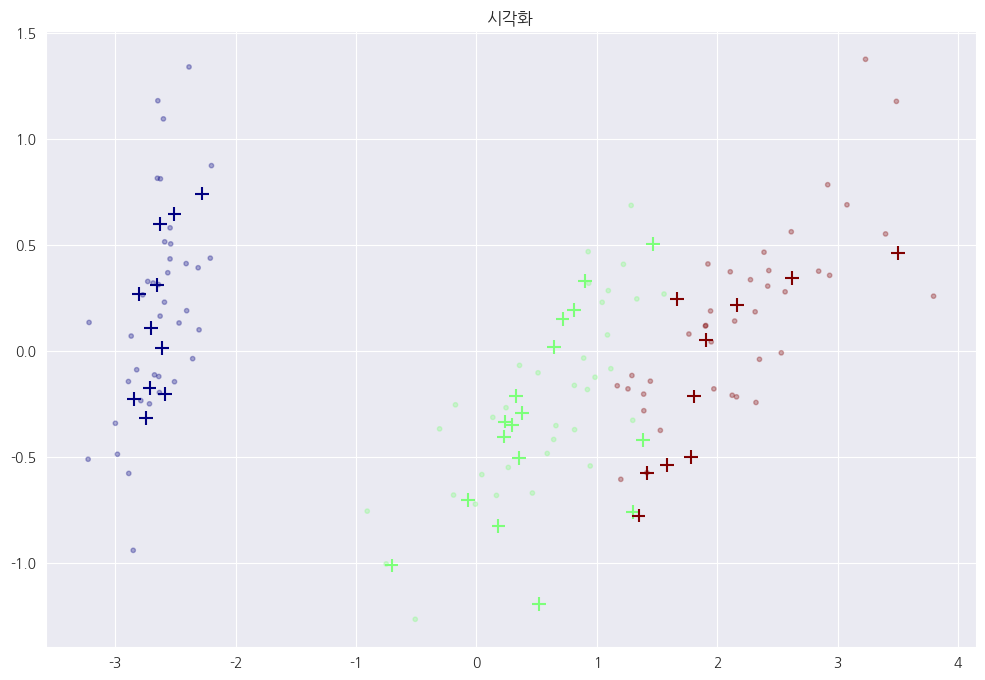

In [35]:
# 필요한 모듈 임포트
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import SVC
import seaborn as sns

iris = sns.load_dataset('iris')

# 라벨인코딩
le = LabelEncoder()
le.fit(iris['species'])
iris['species_label'] = le.transform(iris['species'])

# x, y 추출
x = iris.iloc[:, :-2]
y = iris.iloc[:, -1]

# train, test split
x_train, x_test, y_train, y_test = train_test_split(x, y)

# SVC 모델 준비
model = SVC()
model.fit(x_train, y_train)

# 예측값 생성
y_pred = model.predict(x_test)

# 평가질
from sklearn.metrics import (accuracy_score,
                             classification_report,
                             confusion_matrix)

# 시각화를 위해서 PCA 변환
pca = PCA(n_components=2)
pca.fit(x)
x_train_pca = pca.transform(x_train)
x_test_pca = pca.transform(x_test)

# 시각화
import matplotlib.pyplot as plt
import koreanize_matplotlib

plt.figure(figsize=(12, 8))
plt.title("시각화")

plt.scatter(x_train_pca[:, 0], x_train_pca[:, 1], c=y_train, cmap='jet', s=10, alpha=0.3)
plt.scatter(x_test_pca[:, 0], x_test_pca[:, 1], c=y_pred, cmap='jet', marker='+', s=100)



###

In [ ]:
# 모델 평가
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# 세 가지 평가 방법
# 1. 단순 분류 정확도
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

In [ ]:
# 2. 분류 리포트
report = classification_report(y_test, y_pred, target_names=le.classes_)
print("Classification Report:\n", report)
# precision: 각 항목별 (테스트 데이터) 예측 성공률
# recall: 각 항목별 (훈련 데이터) 예측 성공률
# f1-score: precision과 recall의 조화 평균
# support: 각 항목별 실제 데이터 개수
# accuracy: 전체 데이터에 대한 정확도
# macro avg: 각 항목별 f1-score의 단순평균 (항목 크기 차이 무시)
# weighted avg: 각 항목별 f1-score의 가중평균 (항목 크기 반영)

In [ ]:
# 3. 혼동 행렬
cm = confusion_matrix(y_test, y_pred)

# 시각화
import seaborn as sns
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.title('혼동행렬')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

### Example. `titanic` 데이터셋에서 `embark_town` 분류하는 SVC 만들기

앞서 배운 Label Encoding을 사용하여 문자로 된 열을 숫자 정보로 교체하고, 이후 SVC 모델로 원하는 분류 예측을 수행하는 예시이다.

이 예시에서 Label Encoding을 언제, 왜 사용하는지 이해해야 한다.

In [ ]:
titanic = sns.load_dataset('titanic')
titanic.head()

In [ ]:
yy = titanic['embark_town']
le_y = LabelEncoder()
titanic['embark_town_label'] = le_y.fit_transform(yy)
titanic.head()

In [ ]:
# x 값으로 쓰고 싶은 열, survived, pclass, sex, age, fare, class, who
# 문자 열들을 라벨로 변경
le_sex = LabelEncoder()
titanic['sex'] = le_sex.fit_transform(titanic.sex)
le_who = LabelEncoder()


### Practice3. SVM 모델 선언, 학습, 평가하기

1. `titanic` 데이터셋에서 생존 여부를 예측하는 SVM 모델을 만들고 평가하시오.

2. `penguins` 데이터셋에서 종을 예측하는 SVM 모델을 만들고 평가하시오.

In [ ]:
titanic = sns.load_dataset('titanic')
titanic

In [ ]:
yy = titanic['survived']

# sex, who, adult_male, embark_town, alone을 label 인코딩으로 변환
le_sex = LabelEncoder()
titanic['sex'] = le_sex.fit_transform(titanic.sex)
le_who = LabelEncoder()
titanic['who'] = le_who.fit_transform(titanic.who)
le_adult_m = LabelEncoder()
titanic['adult_male'] = le_adult_m.fit_transform(titanic.adult_male)
le_embark_town = LabelEncoder()
titanic['embark_town'] = le_embark_town.fit_transform(titanic.embark_town)
le_alone = LabelEncoder()
titanic['alone'] = le_alone.fit_transform(titanic.alone)

titanic

# 정리


In [ ]:
titanic = sns.load_dataset('titanic')
titanic

le_alive = LabelEncoder()
alive_label = le_alive.fit_transform(titanic['alive'])
titanic['alive_label'] = alive_label

xx = titanic[['fare', 'pclass', 'sibsp']]
yy = titanic['alive_label']


In [ ]:
# tts
x_train, x_test, y_train, y_test = train_test_split(xx, yy, test_size=0.2)

In [ ]:
# PCA 차원감소
pca = PCA(n_components=2)
pca.fit(x_train)
x_train_pca = pca.transform(x_train)
x_test_pca = pca.transform(x_test)

In [ ]:
# SVC 모델
svc = SVC(kernel='rbf')
svc.fit(x_train, y_train)
y_pred = svc.predict(x_test)
y_pred

In [ ]:
# 시각화
plt.figure(figsize=(10, 6))
plt.title('SVC Model on Titanic Dataset')

# 점
plt.scatter(x_train_pca[:, 0],
            x_train_pca[:, 1],
            c=y_train, cmap='jet',
            label='Train', alpha=0.3)

# 점
plt.scatter(x_test_pca[:, 0],
            x_test_pca[:, 1],
            c=y_pred, cmap='jet',
            label='Test', marker='d', alpha=0.7)

plt.show()

In [ ]:
# SVC 점수
svc.score(x_test, y_test)
